In [1]:
import gym
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random


random.seed()
%matplotlib inline

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# base code from udacity-deep-learning/reinforcement/Q-learning-cart.ipynb

In [2]:

# [-1,1] [-0.2,1.2] [-2,2] [0.5,-2]  [3.5,-3.5]  [6,-6] [1,0]  [1,0]
# Create new cart pole environment
env = gym.make('LunarLander-v2')
state = env.reset()
print(state)
print(np.shape(state))
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)
maxy = -999.
miny = 999.
num = 3
for a in range(100):
    
    while done is not True:
#         env.render()
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        comp = next_state[num]
        if (comp > maxy):
            maxy = comp

        if (comp < miny):
            miny = comp
            
    env.reset()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
        
print(maxy,miny)

# print(action)
print(np.shape(action))
env.close()

[2017-06-27 23:32:44,859] Making new env: LunarLander-v2


[-0.0041213   0.93799163 -0.41746902 -0.17479456  0.00478245  0.09456285
  0.          0.        ]
(8,)
0.533734957377 -1.82325960795
()


In [3]:
def leaky_relu(x,alpha=0.02):
    return tf.maximum(alpha*x,x)

# Create class QNetwork
class QNetwork:
    def __init__(self, \
                 learning_rate=0.01, \
                 state_size=8, 
                 action_size=4, \
                 hidden_size=10, \
                 hidden_layers=2, \
                 alpha=0.1, \
                 name='QNetwork'):
        
        # create Q Network
       
        self.inputs_ = tf.placeholder(tf.float32, \
                                      [None, state_size], \
                                      name='state')
        
        self.next_state_ = tf.placeholder(tf.float32, \
                                      [None, state_size], \
                                      name='next_state')
        
        # placeholder for actions, to be one-hot encoded next
        self.actions_ = tf.placeholder(tf.int32, \
                                       [None], \
                                       name='actions')

        # one hot encode actions
        one_hot_actions = tf.one_hot(self.actions_, \
                                     action_size)

        # placeholder for target Qs
        self.targetQs_ = tf.placeholder(tf.float32, \
                                        [None], \
                                        name='target')
         
        self.done_ = tf.placeholder(tf.float32, \
                                   [None], \
                                   name='done')
                
        with tf.variable_scope("Q_network"):
            # ReLU hidden layers
            self.fc1 = tf.layers.dense(self.inputs_, \
                                        hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.relu1 = leaky_relu(self.fc1, alpha)

                
            self.fc2 = tf.layers.dense(self.relu1, hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.relu2 = leaky_relu(self.fc2, alpha)

            # Linear output layer
            self.output = tf.layers.dense(self.relu2, action_size, \
                                          activation=None,\
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())


        with tf.variable_scope("predictor"):
            state_action = tf.concat([self.inputs_,one_hot_actions],axis=1)
            self.prd_fc1 = tf.layers.dense(state_action, \
                                        hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.prd_relu1 = leaky_relu(self.prd_fc1, alpha)
            
            
            self.prd_fc2 = tf.layers.dense(self.prd_relu1, hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.prd_relu2 = leaky_relu(self.prd_fc2, alpha)

            # Linear output layer
            self.prd_output = tf.layers.dense(self.prd_relu2, state_size, \
                                          activation=None,\
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            
        with tf.variable_scope("done"):
             # ReLU hidden layers
            self.dne_fc1 = tf.layers.dense(self.inputs_, \
                                        hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.dne_relu1 = leaky_relu(self.dne_fc1, alpha)


            # Linear output layer
            self.dne_output = tf.layers.dense(self.dne_relu1, action_size, \
                                          activation=None,\
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.dne_output = tf.sigmoid(self.dne_output)
            
        ### Train with loss (targetQ - Q)^2
        # output has length 2, for two actions. This next line chooses
        # one value from output (per row) according to the one-hot encoded actions.
        self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
        
        
        self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
        self.prd_loss = tf.reduce_mean(tf.square(self.prd_output - self.next_state_))
        self.dne_loss = tf.reduce_mean(tf.square(self.dne_output - self.done_))
        
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        self.prd_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.prd_loss)
        self.dne_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.dne_loss)

In [4]:
# create memory class for storing previous experiences
class Memory():
    def __init__(self, max_size = 10000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=True)
        return [self.buffer[ii] for ii in idx]

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def normalize_state(x, denormalize=False):
# [-1,1] [-0.2,1.2] [-2,2] [0.5,-2]  [3.5,-3.5]  [6,-6] [1,0]  [1,0]
    y = x / [1.,1.,2.,1.5,3.5,6.,1.,1.]
#    y = np.reshape(np.shape(y)[0],np.shape(y)[1],np.shape(y)[2],1)
    return y

In [6]:
def initialize_memory_rand_states(memory_size=10000,pretrain_length=20):
    # Initialize the simulation
    state = env.reset()
    state = normalize_state(state)
    
    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):

        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        next_state = normalize_state(next_state)
        if done:
            # The simulation fails so no next state
            next_state = np.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            state = env.reset()
            state = normalize_state(state)
            
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            state = normalize_state(state)
            
    return memory

In [7]:
def train_q_network(train_episodes=500,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.01,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.0001,\
                   memory_size=10000,\
                   batch_size=20,\
                   max_steps=500,\
                   alpha=0.1,\
                   verbose=True,\
                   num_trains=50):
    
    
    mainQN = QNetwork(name='main', hidden_size=hidden_size, hidden_layers=hidden_layers, learning_rate=learning_rate, alpha=alpha)
    
    memory = Memory(max_size=memory_size)# initialize_memory_rand_states(memory_size=memory_size,pretrain_length=batch_size)

    state = env.reset()
    state = normalize_state(state)
    
    #  Create output variables
    total_rewards_tf = tf.placeholder(tf.float32, None, name='total_rewards')
    max_q_tf = tf.placeholder(tf.float32, None, name='max_qs')
    explore_p_tf = tf.placeholder(tf.float32, None, name='explore_p_tf')

    # Add scalar summary trackers
    tf.summary.scalar('total_reward', total_rewards_tf)
    tf.summary.scalar('max_q', max_q_tf)
    tf.summary.scalar('explore_p', explore_p_tf)
    
    merged_tf = tf.summary.merge_all()
    
    # Now train with experiences
    saver = tf.train.Saver()
    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        # Create file writer
        file_writer = tf.summary.FileWriter(log_path,sess.graph)
        
        step = 0
        steps_list = []
        
        for ep in range(train_episodes):
            total_reward = 0
            t = 0
            do_render = os.path.isfile('./render.txt')
            biggest_target = -9e9
            
            while t < max_steps:
                step += 1
                # Uncomment this next line to watch the training
                if do_render:
                    env.render()  

                # Explore or Exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
                
                if t%2==0:
                    rnd = np.random.rand()
                
                if explore_p > np.random.rand():
                    # Make a random action
                    if t%2==0:
                        action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)
                next_state = normalize_state(next_state)
                
                total_reward += reward

                if done:
                    t = t+1
                    # the episode ends so no next state
                    next_state = np.zeros(state.shape)
                    steps_list.append(total_reward)
                    t = max_steps

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = env.reset()
                    state = normalize_state(state)
                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                    
                    
                    
            for count in range(num_trains):
                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = np.zeros((1,4))

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                
                if np.max(targets) > biggest_target:
                    biggest_target = np.max(targets)
                
                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})
            
            rewards_list.append((ep, total_reward))   
            runningMean = np.mean(steps_list[-100:])
            
            summary = sess.run(merged_tf, feed_dict={total_rewards_tf: total_reward, 
                                                     max_q_tf: biggest_target,
                                                     explore_p_tf: explore_p})
            file_writer.add_summary(summary,ep)
            if verbose:
                
                print('Episode: {}'.format(ep),
                      'TReward: {}'.format(total_reward),
                      'Tloss: {:.4f}'.format(loss),
                      'Expl P: {:.4f}'.format(explore_p),
                      'RunMean : {:.4f}'.format(runningMean),
                      'MaxTarg : {:.4f}'.format(biggest_target))
               
            
            
#             if runningMean > 200.:
#                 saver.save(sess, "checkpoints/cartpole.ckpt")
#                 return rewards_list, mainQN, saver, runningMean
            
        saver.save(sess, "checkpoints/cartpole.ckpt")
        return rewards_list, mainQN, saver, runningMean

In [8]:
def plot_rewards(rewards_list):
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.plot(eps, rews, color='grey', alpha=0.3)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

In [9]:
def test_q_network(mainQN, saver, test_episodes=100, test_max_steps=500, render=True):


    avg_rewards = 0.
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
   
        state = env.reset()
        for ep in range(test_episodes):
            t = 0
            while t < test_max_steps:
                if render:
                    env.render() 

                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)
                
                avg_rewards = avg_rewards + reward / test_episodes
                if done:
                    t = test_max_steps
                    state = env.reset()
                    # Take one random step to get the pole and cart moving
                    #state, reward, done, _ = env.step(env.action_space.sample())

                else:
                    state = next_state
                    t += 1
              
    return avg_rewards

In [12]:
def test_and_train_qnetwork(train_episodes=1000,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.01,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.0001,\
                   memory_size=10000,\
                   batch_size=20,\
                   test_episodes=10,\
                   render=False,\
                   alpha=0.,\
                   verbose=True,\
                   num_trains=50):
    
    # reset graph
    tf.reset_default_graph()

    # train q-network
    rewards_list, mainQN, saver, runningMean = train_q_network(train_episodes = train_episodes, \
                                                  gamma=gamma,\
                                                  explore_start=explore_start,\
                                                  explore_stop=explore_stop,\
                                                  decay_rate=decay_rate,\
                                                  hidden_size=hidden_size,\
                                                  hidden_layers=hidden_layers,\
                                                  learning_rate=learning_rate,\
                                                  memory_size=memory_size,\
                                                  batch_size=batch_size,\
                                                  alpha=alpha,\
                                                  verbose=verbose,\
                                                  num_trains=num_trains)

    if verbose:
        # plot training
        plot_rewards(rewards_list)
    
    avg_train_rewards = np.sum([each[1] for each in rewards_list]) / len(rewards_list)
    if verbose:
        print('average training reward = ',avg_train_rewards)

    # test q-network
    avg_test_rewards = 0#test_q_network(mainQN, saver, test_episodes=test_episodes, render=verbose)
    if verbose:
        print('average test reward = ', avg_test_rewards)
    
    return avg_test_rewards, avg_train_rewards, mainQN, saver, len(rewards_list), runningMean


In [11]:
# # test implementation
# average_rewards = test_and_train_qnetwork(train_episodes=100, verbose=False)
# print('average test reward = ', average_rewards)

In [ ]:

train_eps = 2000
verb = False
gamma = [0.99]
decay_rate = [0.0001]
exp_start=1.0
exp_stop=0.1
hidden_size=[64]

learning_rate=[0.001]
batch_size=[128]
num_averages = 1
results = []
alpha_relu = [0.1,0.02]
mem_sizes = [100000]
num_trains = [128]

env = gym.make('LunarLander-v2')
env.reset()

#log_path = './logs/2/logs_exp_1.0_0.05_no_third_conv_max_record'

for gaIndex in range(len(gamma)):
    for drIndex in range(len(decay_rate)):
        for hs in hidden_size:
            for lr in learning_rate:
                for bs in batch_size:
                    for memS in mem_sizes:
                        for numTrs in num_trains:
                            ga = gamma[gaIndex]
                            dr = decay_rate[drIndex]
                            log_path = './logs/12/dr1='+str(dr)+'_ga='+str(ga)+'_hs='+str(hs)+'_lr'+str(lr)+'_bs'+str(bs)+'_ms='+str(memS)+'_nt='+str(numTrs)
                            average_test_rewards = 0.
                            average_train_rewards = 0.
                            for i in range(num_averages):
                                test,train, mainQN, saver, num_episodes, runningMean = test_and_train_qnetwork(memory_size=memS,\
                                                       train_episodes=train_eps,\
                                                       gamma=ga,\
                                                       explore_start=exp_start,\
                                                       explore_stop=exp_stop,\
                                                       decay_rate=dr,\
                                                       hidden_size=hs,\
                                                       learning_rate=lr,\
                                                       batch_size=bs,\
                                                       alpha = 0.05,\
                                                       num_trains = numTrs,\
                                                       verbose=verb)
                                average_test_rewards += test
                                average_train_rewards += train

                            average_test_rewards = average_test_rewards / num_averages
                            average_train_rewards = average_train_rewards / num_averages
                            results.append([log_path+' test='+str(average_test_rewards)+'  numEps='+str(num_episodes)+'  runMean='+str(runningMean)])
                            clear_output()
                            for each in results:
                                print(each)
# env.close()

[2017-06-28 00:46:11,429] Making new env: LunarLander-v2
[2017-06-28 00:46:11,452] Clearing 24 monitor files from previous run (because force=True was provided)
[2017-06-28 00:46:12,069] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000000.mp4
[2017-06-28 00:46:15,709] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000001.mp4


Episode: 0 TReward: -355.71652686533355 Tloss: 4.6672 Expl P: 0.9902 RunMean : -355.7165 MaxTarg : 3.3150
Episode: 1 TReward: -422.4341272146723 Tloss: 10.1193 Expl P: 0.9833 RunMean : -389.0753 MaxTarg : -2.5633
Episode: 2 TReward: -187.69979146182447 Tloss: 6.0817 Expl P: 0.9753 RunMean : -321.9501 MaxTarg : -55.4907
Episode: 3 TReward: -173.63449558948741 Tloss: 4.2098 Expl P: 0.9674 RunMean : -284.8712 MaxTarg : -26.5770
Episode: 4 TReward: -421.8406635506046 Tloss: 16.2147 Expl P: 0.9582 RunMean : -312.2651 MaxTarg : -9.8808
Episode: 5 TReward: -140.68886603864496 Tloss: 148.2659 Expl P: 0.9478 RunMean : -283.6691 MaxTarg : 54.5246


[2017-06-28 00:46:19,277] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000008.mp4


Episode: 6 TReward: -152.31430995849487 Tloss: 14.5655 Expl P: 0.9371 RunMean : -264.9041 MaxTarg : 67.6912
Episode: 7 TReward: -334.78113166569676 Tloss: 56.3967 Expl P: 0.9300 RunMean : -273.6387 MaxTarg : 74.2359
Episode: 8 TReward: -535.8360706348817 Tloss: 14.9588 Expl P: 0.9213 RunMean : -302.7718 MaxTarg : 83.0823
Episode: 9 TReward: -136.79077071783485 Tloss: 103.5427 Expl P: 0.9149 RunMean : -286.1737 MaxTarg : 97.9388
Episode: 10 TReward: -165.78301511361258 Tloss: 99.9792 Expl P: 0.9080 RunMean : -275.2291 MaxTarg : 126.7464
Episode: 11 TReward: -143.2623496113977 Tloss: 33.0445 Expl P: 0.9019 RunMean : -264.2318 MaxTarg : 130.0727
Episode: 12 TReward: -180.9124273428655 Tloss: 43.3884 Expl P: 0.8934 RunMean : -257.8227 MaxTarg : 116.5408
Episode: 13 TReward: -586.834074012649 Tloss: 112.0366 Expl P: 0.8856 RunMean : -281.3235 MaxTarg : 104.4845
Episode: 14 TReward: -235.24630025283028 Tloss: 6.1450 Expl P: 0.8810 RunMean : -278.2517 MaxTarg : 104.0240
Episode: 15 TReward: -

[2017-06-28 00:46:27,753] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000027.mp4


Episode: 25 TReward: -197.77232472449208 Tloss: 13.6230 Expl P: 0.7995 RunMean : -248.0239 MaxTarg : 153.8004
Episode: 26 TReward: -246.606520266161 Tloss: 20.0920 Expl P: 0.7928 RunMean : -247.9714 MaxTarg : 162.5304
Episode: 27 TReward: -250.16331761208232 Tloss: 14.3713 Expl P: 0.7831 RunMean : -248.0497 MaxTarg : 154.6906
Episode: 28 TReward: -51.3439727053826 Tloss: 20.2002 Expl P: 0.7720 RunMean : -241.2667 MaxTarg : 158.2298
Episode: 29 TReward: -452.883331648419 Tloss: 4.1158 Expl P: 0.7610 RunMean : -248.3206 MaxTarg : 151.7967
Episode: 30 TReward: -144.00955095504253 Tloss: 25.6486 Expl P: 0.7501 RunMean : -244.9557 MaxTarg : 157.5637
Episode: 31 TReward: -149.18317575898658 Tloss: 17.9981 Expl P: 0.7430 RunMean : -241.9628 MaxTarg : 144.3835
Episode: 32 TReward: -242.4647948179116 Tloss: 14.3791 Expl P: 0.7344 RunMean : -241.9781 MaxTarg : 132.4781
Episode: 33 TReward: -141.1579387992797 Tloss: 9.4287 Expl P: 0.7222 RunMean : -239.0128 MaxTarg : 137.5748
Episode: 34 TReward:

[2017-06-28 00:46:52,789] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000064.mp4


Episode: 68 TReward: -270.1160287230708 Tloss: 10.1229 Expl P: 0.3784 RunMean : -217.4308 MaxTarg : 71.8323
Episode: 69 TReward: -273.50302208573976 Tloss: 3.4629 Expl P: 0.3684 RunMean : -218.2935 MaxTarg : 74.3936
Episode: 70 TReward: -78.25750910969812 Tloss: 4.0244 Expl P: 0.3553 RunMean : -218.2935 MaxTarg : 77.6861
Episode: 71 TReward: -53.97225432456193 Tloss: 9.6816 Expl P: 0.3429 RunMean : -215.8038 MaxTarg : 79.8016
Episode: 72 TReward: -82.83800723301725 Tloss: 67.7024 Expl P: 0.3310 RunMean : -215.8038 MaxTarg : 76.4830
Episode: 73 TReward: -62.081101283704925 Tloss: 22.8510 Expl P: 0.3198 RunMean : -213.5094 MaxTarg : 78.7195
Episode: 74 TReward: -33.4411285063727 Tloss: 12.3065 Expl P: 0.3091 RunMean : -213.5094 MaxTarg : 74.6917
Episode: 75 TReward: -145.9030908149359 Tloss: 18.2268 Expl P: 0.2989 RunMean : -212.5152 MaxTarg : 70.9625
Episode: 76 TReward: -36.98854801228164 Tloss: 2.4063 Expl P: 0.2892 RunMean : -212.5152 MaxTarg : 71.0552
Episode: 77 TReward: -104.57113

[2017-06-28 00:49:31,277] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000125.mp4


Episode: 189 TReward: -40.06346761543985 Tloss: 17.1901 Expl P: 0.1007 RunMean : -125.1104 MaxTarg : 109.4008
Episode: 190 TReward: 23.613495970125467 Tloss: 2.8167 Expl P: 0.1006 RunMean : -125.1104 MaxTarg : 100.0822
Episode: 191 TReward: -115.27307814696826 Tloss: 29.1081 Expl P: 0.1006 RunMean : -124.2854 MaxTarg : 113.3439
Episode: 192 TReward: -1.8662539345656426 Tloss: 6.9764 Expl P: 0.1006 RunMean : -124.2854 MaxTarg : 112.7641
Episode: 193 TReward: 81.70542925033985 Tloss: 7.0758 Expl P: 0.1005 RunMean : -121.0023 MaxTarg : 111.4901
Episode: 194 TReward: -44.49542353507231 Tloss: 11.0022 Expl P: 0.1005 RunMean : -121.0023 MaxTarg : 104.4461
Episode: 195 TReward: -159.02334517603967 Tloss: 1.7943 Expl P: 0.1005 RunMean : -120.0909 MaxTarg : 110.5552
Episode: 196 TReward: 44.67290058769834 Tloss: 1.7247 Expl P: 0.1005 RunMean : -120.0909 MaxTarg : 100.2341
Episode: 197 TReward: -87.816984666701 Tloss: 3.6750 Expl P: 0.1004 RunMean : -120.4556 MaxTarg : 98.8176
Episode: 198 TRewa

[2017-06-28 00:53:20,074] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000216.mp4


Episode: 361 TReward: 203.01690862169 Tloss: 1.1311 Expl P: 0.1000 RunMean : -43.5279 MaxTarg : 100.0000
Episode: 362 TReward: -93.00048920651358 Tloss: 0.8059 Expl P: 0.1000 RunMean : -43.5279 MaxTarg : 100.0000
Episode: 363 TReward: -57.827613611918764 Tloss: 0.9318 Expl P: 0.1000 RunMean : -42.4029 MaxTarg : 100.0000
Episode: 364 TReward: 23.115235528279282 Tloss: 0.8259 Expl P: 0.1000 RunMean : -42.4029 MaxTarg : 100.0000
Episode: 365 TReward: 125.7929282301665 Tloss: 1.3431 Expl P: 0.1000 RunMean : -40.5747 MaxTarg : 94.8341
Episode: 366 TReward: -27.634069546332444 Tloss: 2.7774 Expl P: 0.1000 RunMean : -40.5747 MaxTarg : 100.0000
Episode: 367 TReward: -46.261021101112014 Tloss: 0.6602 Expl P: 0.1000 RunMean : -40.1891 MaxTarg : 100.0000
Episode: 368 TReward: 28.266412076514392 Tloss: 0.7518 Expl P: 0.1000 RunMean : -40.1891 MaxTarg : 100.0000
Episode: 369 TReward: 97.91783105136213 Tloss: 0.6819 Expl P: 0.1000 RunMean : -38.1088 MaxTarg : 100.0000
Episode: 370 TReward: 23.349083

[2017-06-28 00:57:46,528] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000343.mp4


Episode: 598 TReward: 105.69870840750238 Tloss: 1.3138 Expl P: 0.1000 RunMean : 24.4656 MaxTarg : 100.0000
Episode: 599 TReward: -27.81379530196008 Tloss: 2.9666 Expl P: 0.1000 RunMean : 24.4656 MaxTarg : 100.0000
Episode: 600 TReward: 127.09393411153573 Tloss: 13.2163 Expl P: 0.1000 RunMean : 26.3083 MaxTarg : 119.7153
Episode: 601 TReward: 45.59014902959788 Tloss: 41.3511 Expl P: 0.1000 RunMean : 26.3083 MaxTarg : 100.0000
Episode: 602 TReward: 114.03451697744578 Tloss: 1.3236 Expl P: 0.1000 RunMean : 26.2686 MaxTarg : 109.2267
Episode: 603 TReward: -17.110277489246737 Tloss: 31.3660 Expl P: 0.1000 RunMean : 26.2686 MaxTarg : 102.1754
Episode: 604 TReward: 96.35375024993299 Tloss: 0.6758 Expl P: 0.1000 RunMean : 29.0853 MaxTarg : 114.5683
Episode: 605 TReward: 16.112897779408797 Tloss: 1.5414 Expl P: 0.1000 RunMean : 29.0853 MaxTarg : 119.5310
Episode: 606 TReward: 131.19242956449503 Tloss: 1.9047 Expl P: 0.1000 RunMean : 29.9669 MaxTarg : 116.9312
Episode: 607 TReward: 31.1890516774

[2017-06-28 01:01:35,240] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000512.mp4


Episode: 850 TReward: 183.7159401858304 Tloss: 43.8689 Expl P: 0.1000 RunMean : 134.4186 MaxTarg : 100.0000
Episode: 851 TReward: 210.23248341604113 Tloss: 1.5070 Expl P: 0.1000 RunMean : 135.5066 MaxTarg : 100.0000
Episode: 852 TReward: 190.90551381844423 Tloss: 0.4985 Expl P: 0.1000 RunMean : 136.3339 MaxTarg : 100.0000
Episode: 853 TReward: 198.40058464757993 Tloss: 3.7211 Expl P: 0.1000 RunMean : 138.5046 MaxTarg : 100.0000
Episode: 854 TReward: 254.3361393861277 Tloss: 0.7445 Expl P: 0.1000 RunMean : 140.0480 MaxTarg : 106.9514
Episode: 855 TReward: 185.0691276279382 Tloss: 1.3211 Expl P: 0.1000 RunMean : 139.8217 MaxTarg : 106.8914
Episode: 856 TReward: 236.05433722353806 Tloss: 0.9212 Expl P: 0.1000 RunMean : 140.8991 MaxTarg : 105.9383
Episode: 857 TReward: 265.71405440750914 Tloss: 2.6093 Expl P: 0.1000 RunMean : 141.4168 MaxTarg : 108.8443
Episode: 858 TReward: -39.023771489316914 Tloss: 1.2563 Expl P: 0.1000 RunMean : 139.1207 MaxTarg : 105.2170
Episode: 859 TReward: 223.767

[2017-06-28 01:05:14,351] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video000729.mp4


Episode: 1123 TReward: 74.87885299273424 Tloss: 1.4411 Expl P: 0.1000 RunMean : 127.3126 MaxTarg : 116.4195
Episode: 1124 TReward: -68.98506045700437 Tloss: 0.8631 Expl P: 0.1000 RunMean : 125.3222 MaxTarg : 108.0507
Episode: 1125 TReward: 225.9683789438671 Tloss: 3.3011 Expl P: 0.1000 RunMean : 125.3497 MaxTarg : 115.8116
Episode: 1126 TReward: 156.11058079206114 Tloss: 30.9411 Expl P: 0.1000 RunMean : 124.9181 MaxTarg : 106.5410
Episode: 1127 TReward: 94.56232976794804 Tloss: 1.4033 Expl P: 0.1000 RunMean : 124.9181 MaxTarg : 125.4401
Episode: 1128 TReward: -6.730682692169477 Tloss: 28.4614 Expl P: 0.1000 RunMean : 123.9185 MaxTarg : 123.9001
Episode: 1129 TReward: 218.1002710998393 Tloss: 4.5669 Expl P: 0.1000 RunMean : 124.0495 MaxTarg : 100.9053
Episode: 1130 TReward: 190.1063503024934 Tloss: 3.2738 Expl P: 0.1000 RunMean : 127.0768 MaxTarg : 105.4837
Episode: 1131 TReward: 118.56708732158145 Tloss: 1.0984 Expl P: 0.1000 RunMean : 127.0768 MaxTarg : 105.0470
Episode: 1132 TReward:

[2017-06-28 01:09:35,290] Starting new video recorder writing to D:\tmp\lunarlander-experiment-1\openaigym.video.4.10616.video001000.mp4


Episode: 1464 TReward: 223.51977612153212 Tloss: 0.5675 Expl P: 0.1000 RunMean : 181.0583 MaxTarg : 110.1052
Episode: 1465 TReward: 69.08415462099467 Tloss: 1.0841 Expl P: 0.1000 RunMean : 181.0583 MaxTarg : 114.8658
Episode: 1466 TReward: 100.09157481902503 Tloss: 37.0947 Expl P: 0.1000 RunMean : 179.9437 MaxTarg : 116.1826
Episode: 1467 TReward: 227.36299664289564 Tloss: 0.6947 Expl P: 0.1000 RunMean : 180.5151 MaxTarg : 109.2742
Episode: 1468 TReward: 187.42396726931605 Tloss: 2.0078 Expl P: 0.1000 RunMean : 181.3893 MaxTarg : 103.5691
Episode: 1469 TReward: 14.225831819368693 Tloss: 4.2451 Expl P: 0.1000 RunMean : 179.9924 MaxTarg : 111.9442
Episode: 1470 TReward: 221.36114680784638 Tloss: 17.7541 Expl P: 0.1000 RunMean : 180.8977 MaxTarg : 110.5900
Episode: 1471 TReward: 231.6606635752288 Tloss: 16.5000 Expl P: 0.1000 RunMean : 181.1927 MaxTarg : 106.0499
Episode: 1472 TReward: 229.04151694377268 Tloss: 0.5502 Expl P: 0.1000 RunMean : 181.1266 MaxTarg : 104.4970
Episode: 1473 TRew

[2017-06-28 01:16:01,662] Finished writing results. You can upload them to the scoreboard via gym.upload('D:\\tmp\\lunarlander-experiment-1')


average training reward =  80.7019326371
average test reward =  0
test= 0
80.7019326371
number of episodes= 2000


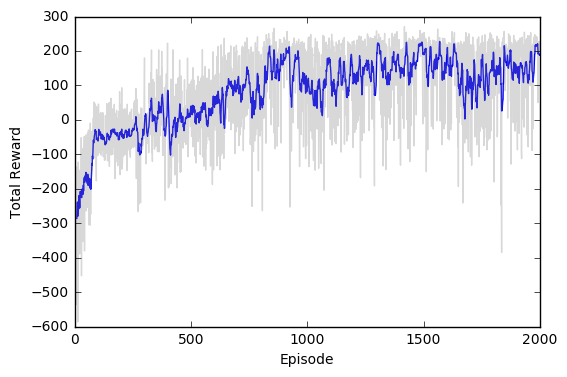

In [17]:
from gym import wrappers
log_path = './logs/14/logs_run_9'  

env = gym.make('LunarLander-v2')
env = wrappers.Monitor(env, '/tmp/lunarlander-experiment-1',force=True)

test,train, mainQN, saver, num_episodes, runningMean = test_and_train_qnetwork(memory_size=100000,\
                                     train_episodes=2000,\
                                           gamma=0.985,\
                                           explore_start=1.,\
                                           explore_stop=0.1,\
                                           decay_rate=0.0001,\
                                           hidden_layers=1,\
                                           hidden_size=64,\
                                           learning_rate=0.001,\
                                           batch_size=128,\
                                           alpha=0.1,\
                                           num_trains = 128,\
                                           verbose=True)
print('test=',str(test))
print(train)
print('number of episodes=',str(num_episodes))
env.close()

In [ ]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1',force=True)
avg_test_rewards = test_q_network(mainQN, saver, test_episodes=200, render=False)
print(avg_test_rewards)
env.close
#     if verbose:
#         print('average test reward = ', avg_test_rewards)
    
#     return avg_test_rewards, avg_train_rewards, mainQN, saver

In [ ]:
env.close()
gym.upload('/tmp/cartpole-experiment-1', api_key='')

In [ ]:
import gym
from gym import wrappers
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/cartpolev1-experiment-1',force=True)
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break